# Wide and Deep Model for Movie Recommendation
광범위한 교차 열 특성의 집합을 가진 선형 모델은 특성들의 상호작용을 기억할 수 있습니다. DNN은 희소 특성에 대해 학습된 저차원 밀도 임베딩을 통해 특성 패턴을 일반화할 수 있습니다. *Wide-and-deep* 모델은 선형 모델과 DNN을 합동으로 훈련시켜 추천 시스템을 위한 일반화와 기억의 이점을 모두 얻습니다.   
이 문서의 순서는 다음과 같습니다.
- 데이터 준비
- 모델 빌드
- Use log-hook to estimate performance while training
- 모델 테스트 및 추출

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

`TemporaryDirectory()`는 임시 디렉토리를 생성하고, `close()` 호출 또는 프로그램 종료 시 디렉토리 삭제

In [2]:
import itertools
import math
import os
from tempfile import TemporaryDirectory

In [3]:
import numpy as np
import scrapbook as sb
import pandas as pd
import sklearn.preprocessing
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

from recommenders.utils.constants import(DEFAULT_USER_COL as USER_COL,
                                        DEFAULT_ITEM_COL as ITEM_COL,
                                        DEFAULT_RATING_COL as RATING_COL,
                                        DEFAULT_PREDICTION_COL as PREDICT_COL,
                                        DEFAULT_GENRE_COL as ITEM_FEAT_COL, SEED)
from recommenders.utils import tf_utils, gpu_utils, plot
from recommenders.datasets import movielens
from recommenders.datasets.pandas_df_utils import user_item_pairs
from recommenders.datasets.python_splitters import python_random_split
import recommenders.evaluation.python_evaluation as evaluator
import recommenders.models.wide_deep.wide_deep_utils as wide_deep

print('Tensorflow Version:', tf.__version__)
print('GPUs:\n', gpu_utils.get_gpu_info())


Tensorflow Version: 2.7.3
GPUs:
 [{'device_name': 'NVIDIA GeForce GTX 1650', 'total_memory': 3908.875, 'free_memory': 3032.5625}]


In [4]:
# Parameters
TOP_K = 10
Movielens_data_size = '100k'

# Metrics to use for evaluation
ranking_metrics = [evaluator.ndcg_at_k.__name__, evaluator.precision_at_k.__name__]
rating_metrics = [evaluator.rmse.__name__, evaluator.mae.__name__]

# Use session hook to evaluate model while training
Evaluate_while_training = True
Random_seed = SEED

# Train and test set pickle file paths.
Data_dir = None
Train_pickle_path = None
Test_pickle_path = None
Export_dir_base = './outputs/model'
# Model checkpoints directory. If None, use temp-dir
Model_dir = None

## Hyperparameters
Model_type = 'wide_deep'
Steps = 50000
Batch_size = 32
# Wide model hyperparameters
Linear_optimizer = 'adagrad'
Linear_optimizer_lr = 0.0621
Linear_l1_reg = 0.0 # Regularization rate for Ftrloptimizer
Linear_l2_reg = 0.0
Linear_momentum = 0.0
# DNN hyperparameters
Dnn_optimizer = 'adadelta'
Dnn_optimizer_lr = 0.1
Dnn_l1_reg = 0.0
Dnn_l2_reg = 0.0
Dnn_momentum = 0.0

# Layer dimensions.
DNN_HIDDEN_LAYER_1 = 0     # Set 0 to not use this layer
DNN_HIDDEN_LAYER_2 = 64    # Set 0 to not use this layer
DNN_HIDDEN_LAYER_3 = 128   # Set 0 to not use this layer
DNN_HIDDEN_LAYER_4 = 512   # Note, at least one layer should have nodes.
DNN_HIDDEN_UNITS = [h for h in [DNN_HIDDEN_LAYER_1, DNN_HIDDEN_LAYER_2, DNN_HIDDEN_LAYER_3, DNN_HIDDEN_LAYER_4] if h > 0]
DNN_USER_DIM = 32          # User embedding feature dimension
DNN_ITEM_DIM = 16          # Item embedding feature dimension
DNN_DROPOUT = 0.8
DNN_BATCH_NORM = 1         # 1 to use batch normalization, 0 if not.

In [5]:
if Model_dir is None:
    tmp_dir = TemporaryDirectory()
    model_dir = tmp_dir.name
else:
    if os.path.exists(Model_dir) and os.listdir(Model_dir):
        raise ValueError(
        "Model exists in {}. Use different directory name or "
            "remove the existing checkpoint files first".format(MODEL_DIR))
    tmp_dir = None
    model_dir = Model_dir

## 1. Prepare Data
### 1.1 Movie Rating and Genres Data

In [6]:
use_preset = (Train_pickle_path is not None and Test_pickle_path is not None)

In [7]:
if not use_preset:
    data = movielens.load_pandas_df(size=Movielens_data_size,
                                   header=[USER_COL, ITEM_COL, RATING_COL],
                                   genres_col=ITEM_FEAT_COL)
    display(data.head())

100%|█████████████████████████████████████| 4.81k/4.81k [00:02<00:00, 1.97kKB/s]


,userID,itemID,rating,genre
0,196,242,3.0,Comedy
1,63,242,3.0,Comedy
2,226,242,5.0,Comedy
3,154,242,3.0,Comedy
4,306,242,5.0,Comedy


### 1.2 Encode Item Features(Genres)
모델에서 장르 특성을 사용하기 위해 scikit-learn의 `MultiLabelBinarizer`를 이용해 멀티-핫-인코딩을 수행한다.      
> 더 빠른 특성 인코딩을 위해, ratings와 items를 각각 로드하고 item-features를 인코딩한 후 `join()`을 이용해 item 데이터프레임과 ratings를 결합할 수 있다.

In [8]:
if not use_preset and ITEM_FEAT_COL is not None:
    genres_encoder = sklearn.preprocessing.MultiLabelBinarizer()
    data[ITEM_FEAT_COL] = genres_encoder.fit_transform(
        data[ITEM_FEAT_COL].apply(lambda s:s.split('|'))).tolist()
    print('Genres:', genres_encoder.classes_)
    display(data.head())

Genres: ['Action' 'Adventure' 'Animation' "Children's" 'Comedy' 'Crime'
 'Documentary' 'Drama' 'Fantasy' 'Film-Noir' 'Horror' 'Musical' 'Mystery'
 'Romance' 'Sci-Fi' 'Thriller' 'War' 'Western' 'unknown']


,userID,itemID,rating,genre
0,196,242,3.0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,63,242,3.0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,226,242,5.0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,154,242,3.0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,306,242,5.0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### 1.3 Train and Test Split

In [9]:
if not use_preset:
    print('Not use_preset')
    train, test = python_random_split(data, ratio=0.75, seed=Random_seed)
else:
    print('Use_preset')
    train = pd.read_pickle(path=Train_pickle_path if Data_dir is None else os.path.join(Data_dir, Train_pickle_path))
    test = pd.read_pickle(path=Test_pickle_path if Data_dir is None else os.path.join(Data_dir, Test_pickle_path))
    data = pd.concat([train, test])
    
print('{} train samples and {} test samples'.format(len(train), len(test)))

Not use_preset
75000 train samples and 25000 test samples


In [10]:
if ITEM_FEAT_COL is None:
    print('ITEM_FEAT_COL is None')
    items = data.drop_duplicates(ITEM_COL)[[ITEM_COL]].reset_index(drop=True)
    item_feat_shape = None
else:
    print('ITEM_FEAR_COL in not None')
    items = data.drop_duplicates(ITEM_COL)[[ITEM_COL, ITEM_FEAT_COL]].reset_index(drop=True)
    item_feat_shape = len(items[ITEM_FEAT_COL][0])
    
users = data.drop_duplicates(USER_COL)[[USER_COL]].reset_index(drop=True)
print('Total {} items and {} users in the dataset'.format(len(items), len(users)))

ITEM_FEAR_COL in not None
Total 1682 items and 943 users in the dataset


## 2. Build Model
*Wide-and-deep*모델은 선형 모델과 DNN 모델로 이루어집니다. 모델에 사용하는 특성들과 하이퍼파리미터는 다음과 같습니다.

<br> | <div align="center">Wide (linear) model</div> | <div align="center">Deep neural networks</div>
---|---|---
Feature set | <ul><li>User-item co-occurrence features<br>to capture how their co-occurrence<br>correlates with the target rating</li></ul> | <ul><li>Deep, lower-dimensional embedding vectors<br>for every user and item</li><li>Item feature vector</li></ul>
Hyperparameters | <ul><li>FTRL optimizer</li><li>Learning rate = 0.0029</li><li>L1 regularization = 0.0</li></ul> | <ul><li>Adagrad optimizer</li><li>Learning rate = 0.1</li><li>Hidden units = [128, 256, 32]</li><li>Dropout rate = 0.4</li><li>Use batch normalization (Batch size = 64)</li><li>User embedding vector size = 4</li><li>Item embedding vector size = 4</li></ul>
<br>

하이퍼파라미터들은 훈련 데이터셋에 최적화된 것을 기억해야 합니다. 최적의 하이퍼파라미터를 찾기 위해 **AzureML**을 사용합니다. 훈련 데이터셋을 훈련과 검증을 위한 각각의 세트로 나누어 테스트 데이터셋이 튜닝과 훈련 과정으로부터 분리되도록 합니다.

In [11]:
# Model checkpoint every n steps.
save_checkpoints_steps = max(1, Steps//5)

# Define wide-and-deep featrues
wide_columns, deep_columns = wide_deep.build_feature_columns(users=users[USER_COL].values,
                                                            items=items[ITEM_COL].values,
                                                            user_col=USER_COL, item_col=ITEM_COL,
                                                            item_feat_col=ITEM_FEAT_COL,
                                                            crossed_feat_dim=1000,
                                                            user_dim=DNN_USER_DIM,
                                                            item_dim=DNN_ITEM_DIM,
                                                            item_feat_shape=item_feat_shape,
                                                            model_type=Model_type)

print('Wide feature specs:')
for c in wide_columns:
    print('\t', str(c)[:100], '...')
print('Deep feature specs:')
for c in deep_columns:
    print('\t', str(c)[:100], '...')

Wide feature specs:
	 VocabularyListCategoricalColumn(key='userID', vocabulary_list=(196, 63, 226, 154, 306, 296, 34, 271, ...
	 VocabularyListCategoricalColumn(key='itemID', vocabulary_list=(242, 302, 377, 51, 346, 474, 265, 465 ...
	 CrossedColumn(keys=(VocabularyListCategoricalColumn(key='userID', vocabulary_list=(196, 63, 226, 154 ...
Deep feature specs:
	 EmbeddingColumn(categorical_column=VocabularyListCategoricalColumn(key='userID', vocabulary_list=(19 ...
	 EmbeddingColumn(categorical_column=VocabularyListCategoricalColumn(key='itemID', vocabulary_list=(24 ...
	 NumericColumn(key='genre', shape=(19,), default_value=None, dtype=tf.float32, normalizer_fn=None) ...


In [12]:
print(model_dir)
print(DNN_HIDDEN_UNITS)
print(DNN_DROPOUT)
print((DNN_BATCH_NORM==1))
print(save_checkpoints_steps)

/tmp/tmptn_rrvzn
[64, 128, 512]
0.8
True
10000


In [13]:
# Build a model based on the parameters
model = wide_deep.build_model(model_dir=model_dir,
                             wide_columns=wide_columns,
                             deep_columns=deep_columns,
                             linear_optimizer=tf_utils.build_optimizer(Linear_optimizer, Linear_optimizer_lr,
                                                                      **{'l1_regularization_strength': Linear_l1_reg,
                                                                        'l2_regularization_strength': Linear_l2_reg,
                                                                        'momentum': Linear_momentum}),
                             dnn_optimizer=tf_utils.build_optimizer(Dnn_optimizer, Dnn_optimizer_lr,
                                                                   **{'l1_regularization_strength': Dnn_l1_reg,
                                                                     'l2_regularization_strength': Dnn_l2_reg,
                                                                     'momentum':Dnn_momentum}),
                             dnn_hidden_units=DNN_HIDDEN_UNITS,
                             dnn_dropout=DNN_DROPOUT,
                             dnn_batch_norm=(DNN_BATCH_NORM==1),
                             log_every_n_iter=max(1, Steps//10),
                             save_checkpoints_steps=save_checkpoints_steps,
                             seed=Random_seed)

## 3. Train and Evaluate Model
아래의 과정에선 훈련 중 모델의 성능을 추적하기 위해 session hooks를 어떻게 활용하는지 볼 수 있습니다. custom hook `tf_utils.evaluation_log_hook`은 특정한 평가 함수에 기반하여 주어진 데이터에 대한 모델의 성능을 평가합니다.   
Note we pass test set to evaluate the model on rating metrics while we use ranking-pool (all the user-item pairs) for ranking metrics.
> TensorFlow Estimator의 기본 손실은 Mean Squared Error를 계산합니다. 이 손실값의 Square root값은 RMSE와 같습니다.

In [14]:
cols = {'col_user': USER_COL, 'col_item':ITEM_COL,
       'col_rating': RATING_COL, 'col_prediction':PREDICT_COL}

# Prepare ranking evaluation set
# Get the cross join of all user-item pairs
ranking_pool = user_item_pairs(user_df=users, item_df=items, user_col=USER_COL, item_col=ITEM_COL,
                              user_item_filter_df=train, shuffle=True, seed=Random_seed)

In [15]:
ranking_pool # user * item + train

,userID,itemID,genre
0,626,1422,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
1,818,219,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
2,75,1639,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
3,352,1491,"[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
4,68,1639,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
1511121,179,811,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1511122,225,1395,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
1511123,866,1054,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1511124,665,916,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."


In [16]:
Evaluate_while_training

True

In [17]:
for met in (ranking_metrics, rating_metrics):
    print(met)

['ndcg_at_k', 'precision_at_k']
['rmse', 'mae']


In [18]:
# Define training hooks to track performance while training
hooks = []
if Evaluate_while_training:
    evaluation_logger = tf_utils.MetricsLogger()
    
    for metrics in (ranking_metrics, rating_metrics):
        if len(metrics) > 0:
            hooks.append(tf_utils.evaluation_log_hook(model,
                                                     logger=evaluation_logger,
                                                     true_df=test,
                                                     y_col=RATING_COL,
                                                     eval_df=ranking_pool if metrics==ranking_metrics else test.drop(RATING_COL, axis=1),
                                                     every_n_iter=save_checkpoints_steps,
                                                     model_dir=model_dir,
                                                     eval_fns=[evaluator.metrics[m] for m in metrics],
                                                     **({**cols, 'k':TOP_K} if metrics==ranking_metrics else cols)
                                                     )
                        )

In [19]:
# Define training input function
train_fn = tf_utils.pandas_input_fn(df=train,
                                   y_col=RATING_COL,
                                   batch_size=Batch_size,
                                   num_epochs=None,
                                   shuffle=True,
                                   seed=Random_seed)

In [20]:
# Train
print(
    "Training steps = {}, Batch size = {} (num epochs = {})"
    .format(Steps, Batch_size, (Steps*Batch_size)//len(train))
)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO)

try:
    model.train(
        input_fn=train_fn,
        hooks=hooks,
        steps=Steps
    )
except tf.train.NanLossDuringTrainingError:
    import warnings
    warnings.warn(
        "Training stopped with NanLossDuringTrainingError. "
        "Try other optimizers, smaller batch size and/or smaller learning rate."
    )

Training steps = 50000, Batch size = 32 (num epochs = 21)
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.


2022-07-06 13:27:53.830843: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 13:27:53.851232: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 13:27:53.851507: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Instructions for updating:
Colocations handled automatically by placer.


/home/qwer/anaconda3/envs/recommender3713/lib/python3.7/site-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.


2022-07-06 13:27:54.893967: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-06 13:27:54.894548: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 13:27:54.894954: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 13:27:54.895198: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


2022-07-06 13:27:55.336302: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 13:27:55.336668: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 13:27:55.336921: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 13:27:55.337254: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1823 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmptn_rrvzn/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


2022-07-06 13:27:59.078359: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 13:27:59.078608: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 13:27:59.078781: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 13:27:59.078973: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 13:27:59.079132: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

INFO:tensorflow:loss = 432.81836, step = 0
INFO:tensorflow:global_step/sec: 130.55
INFO:tensorflow:loss = 37.723717, step = 5000 (19.055 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 10000...
INFO:tensorflow:Saving checkpoints for 10000 into /tmp/tmptn_rrvzn/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 10000...
INFO:tensorflow:global_step/sec: 258.06


/home/qwer/anaconda3/envs/recommender3713/lib/python3.7/site-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)
2022-07-06 13:28:56.812741: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 13:28:56.813004: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 13:28:56.813190: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 13:28:56.813390: I tensorfl

INFO:tensorflow:loss = 18.696344, step = 10000 (39.626 sec)
INFO:tensorflow:global_step/sec: 125.886
INFO:tensorflow:loss = 19.73504, step = 15000 (19.468 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 20000...
INFO:tensorflow:Saving checkpoints for 20000 into /tmp/tmptn_rrvzn/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 20000...
INFO:tensorflow:global_step/sec: 252.583


/home/qwer/anaconda3/envs/recommender3713/lib/python3.7/site-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)
2022-07-06 13:29:56.357914: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 13:29:56.358186: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 13:29:56.358461: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 13:29:56.358674: I tensorfl

INFO:tensorflow:loss = 37.037205, step = 20000 (40.074 sec)
INFO:tensorflow:global_step/sec: 126.533
INFO:tensorflow:loss = 27.588589, step = 25000 (19.237 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 30000...
INFO:tensorflow:Saving checkpoints for 30000 into /tmp/tmptn_rrvzn/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 30000...
INFO:tensorflow:global_step/sec: 258.761


/home/qwer/anaconda3/envs/recommender3713/lib/python3.7/site-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)
2022-07-06 13:30:55.092336: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 13:30:55.092592: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 13:30:55.092750: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 13:30:55.092933: I tensorfl

INFO:tensorflow:loss = 28.585766, step = 30000 (38.516 sec)
INFO:tensorflow:global_step/sec: 131.056
INFO:tensorflow:loss = 28.5495, step = 35000 (18.958 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 40000...
INFO:tensorflow:Saving checkpoints for 40000 into /tmp/tmptn_rrvzn/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 40000...
INFO:tensorflow:global_step/sec: 263.685


/home/qwer/anaconda3/envs/recommender3713/lib/python3.7/site-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)
2022-07-06 13:31:52.189735: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 13:31:52.189997: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 13:31:52.190167: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 13:31:52.190358: I tensorfl

INFO:tensorflow:loss = 25.592495, step = 40000 (39.022 sec)
INFO:tensorflow:global_step/sec: 126.473
INFO:tensorflow:loss = 21.793713, step = 45000 (19.474 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 50000...
INFO:tensorflow:Saving checkpoints for 50000 into /tmp/tmptn_rrvzn/model.ckpt.
Instructions for updating:
Use standard file APIs to delete files with this prefix.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 50000...
INFO:tensorflow:Loss for final step: 23.851135.


In [25]:
Evaluate_while_training

True

dict_items([('ndcg_at_k', [0.014169790473514545, 0.13631889314830622, 0.11435767919152774, 0.10048763332088412, 0.09123567428371479]), ('precision_at_k', [0.013467656415694591, 0.1269353128313892, 0.10858960763520681, 0.09766702014846236, 0.09088016967126195]), ('rmse', [3.7706172275608805, 0.9701681028796701, 0.9577242450968211, 0.954294715046537, 0.9527912032790599]), ('mae', [3.596596347311344, 0.7796027356338501, 0.7643605845475197, 0.7599864740514756, 0.7578072108852864])])


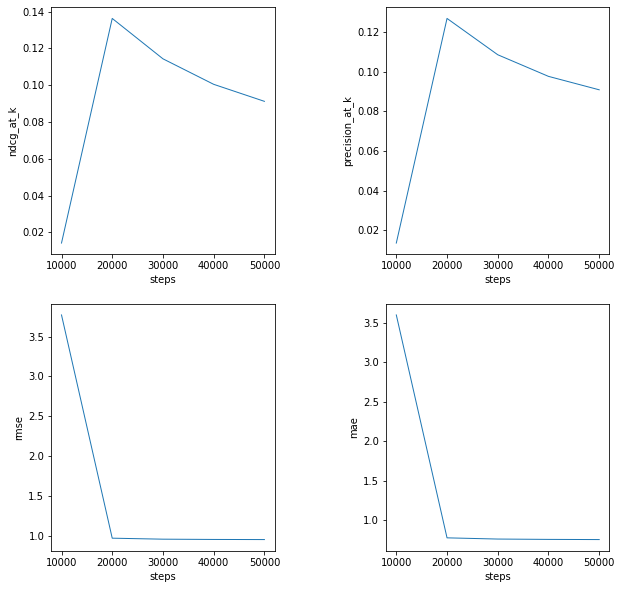

In [21]:
if Evaluate_while_training:
    logs = evaluation_logger.get_log()
    print(logs.items())
    for i, (m,v) in enumerate(logs.items(), 1):
        sb.glue('eval_{}'.format(m), v)
        x = [save_checkpoints_steps*i for i in range(1, len(v)+1)]
        plot.line_graph(values=list(zip(v,x)),
                       labels=m,
                       x_name='steps',
                       y_name=m,
                       subplot=(math.ceil(len(logs)/2), 2, i))

> **Tensor Board**
Yo can browse the details of the training results as well as the metrics we logged from TensorBoard.   
To open the TensorBoard, open a terminal from the same directory of this notebook, run `tensorboard --logdir=model_checkpoints`, and open http://localhost:6006 from a browser.

## 4. Test and Export Model
### 4.1 Item rating prediction

In [22]:
if len(rating_metrics) > 0:
    predictions = list(model.predict(input_fn=tf_utils.pandas_input_fn(df=test)))
    prediction_df = test.drop(RATING_COL, axis=1)
    prediction_df[PREDICT_COL] = [p['predictions'][0] for p in predictions]
    
    rating_results = {}
    for m in ranking_metrics:
        result = evaluator.metrics[m](test, prediction_df, **cols)
        sb.glue(m, result)
        rating_results[m] = result
    print(rating_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmptn_rrvzn/model.ckpt-50000


/home/qwer/anaconda3/envs/recommender3713/lib/python3.7/site-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)
2022-07-06 13:36:21.434005: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 13:36:21.434282: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 13:36:21.434472: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 13:36:21.434682: I tensorfl

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


{'ndcg_at_k': 1.0, 'precision_at_k': 0.8835630965005302}


### 4.2 Recommend k items
Top-k 추천 성능 평가에서 훈련 단계에서 준비한 ranking pool을 이용한다. 조금 다른 점은, 좀 더 자연스러운 추천 시나리오를위해 유저가 이미 경험한 아이템은 지운다는 점이다.

In [24]:
if len(rating_metrics) > 0:
    predictions = list(model.predict(input_fn=tf_utils.pandas_input_fn(df=ranking_pool)))
    prediction_df = ranking_pool.copy()
    prediction_df[PREDICT_COL] = [p['predictions'][0] for p in predictions]
    
    ranking_results = {}
    for m in ranking_metrics:
        result = evaluator.metrics[m](test, prediction_df, **{**cols, 'k':TOP_K})
        sb.glue(m, result)
        ranking_results[m] = result
    print(ranking_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmptn_rrvzn/model.ckpt-50000


/home/qwer/anaconda3/envs/recommender3713/lib/python3.7/site-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)
2022-07-06 13:40:13.824790: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 13:40:13.825149: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 13:40:13.825419: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 13:40:13.825730: I tensorfl

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


{'ndcg_at_k': 0.08599561762704815, 'precision_at_k': 0.08579003181336163}


### Export Model
나중에 재학습, 검증과 예측을 하기 위해 모델을 추출합니다. 추출한 모델을 어떻게 불러오고, 재학습하고 검증하고 저장하는지는 `azureml_hyperdrive_wide_and_deep`에서 다룹니다.

In [25]:
os.makedirs(Export_dir_base, exist_ok=True)

In [26]:
exported_path = tf_utils.export_model(model=model,
                                     train_input_fn=train_fn,
                                     eval_input_fn=tf_utils.pandas_input_fn(df=test,
                                                                           y_col=RATING_COL),
                                     tf_feat_cols=wide_columns+deep_columns,
                                     base_dir=Export_dir_base)
sb.glue('saved_model_dir', str(exported_path))
print('Model exported to', str(exported_path))

/home/qwer/anaconda3/envs/recommender3713/lib/python3.7/site-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)
2022-07-06 14:00:37.821860: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 14:00:37.822151: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 14:00:37.822335: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-06 14:00:37.822547: I tensorfl

Model exported to ./outputs/model/1657083637


In [27]:
# Close the event file so that the model folder can be cleaned up
summary_writer = tf.compat.v1.summary.FileWriterCache.get(model.model_dir)
summary_writer.close()

# Cleanup temporary directory if used
if tmp_dir is not None:
    tmp_dir.cleanup()